# **MOBILENETV2 Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.
- Build and evaluate models: Implement a baseline CNN model, refine it through hyperparameter tuning, and assess performance.
- Analyze model effectiveness: Use Saliency Maps and t-SNE visualization to interpret model predictions and feature separability.
- Compare model performance: Select the best model based on accuracy, loss, and efficiency for real-world deployment.
- Prepare for deployment: Save the optimized model for integration into a Streamlit web app hosted on Heroku.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

Data Processing & Visualization
- Dataset Distribution Plot → Confirmed balanced data split across training, validation, and test sets.
- Data Augmentation Visualization → Showcased applied transformations, including rotation, flipping, and zooming.
Model Training & Optimization
- Baseline CNN Model → Implemented a standard CNN to establish initial performance.
- Hyperparameter-Tuned CNN → Optimized model performance using Keras Tuner (adjusting filters, dropout, learning rate, and L2 regularization).
- Best Model Selection → Chose the Tuned CNN based on test accuracy and generalization ability.
- Saved Trained Models → Final model stored for Streamlit integration and deployment on Heroku.
Model Evaluation & Explainability
- Learning Curves → Visualized loss and accuracy trends over epochs.
- Confusion Matrices → Displayed classification performance for train, validation, and test sets.
- Classification Reports → Provided precision, recall, and F1-score analysis.
- Saliency Maps → Highlighted regions in images that influenced the model’s predictions.
- Feature Space Visualization→ Compared Baseline CNN and Tuned CNN feature separability.

## Additional Comments

- Business Impact: The trained model can assist in early detection of powdery mildew, reducing manual inspection time and improving plantation monitoring efficiency.
- Data-Driven Enhancements: Model improvements were guided by data preprocessing insights, including class balance validation.
- Deployment Readiness: The best model was optimized and prepared for integration into a Streamlit web app for real-world application.



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

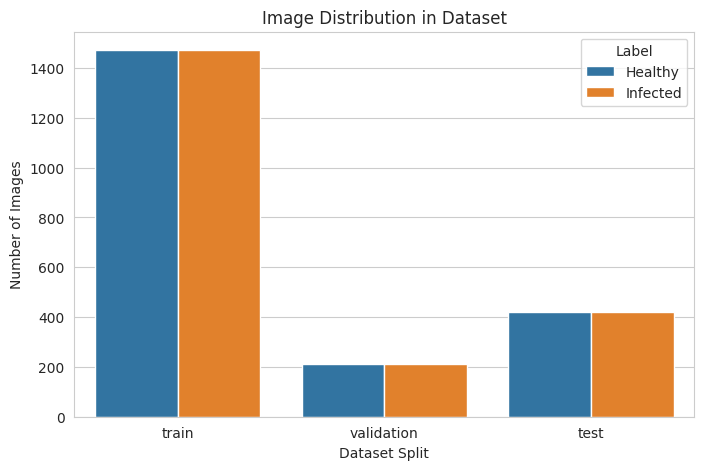

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-27 16:18:08.549860: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 16:18:09.711186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(20, 128, 128, 3)


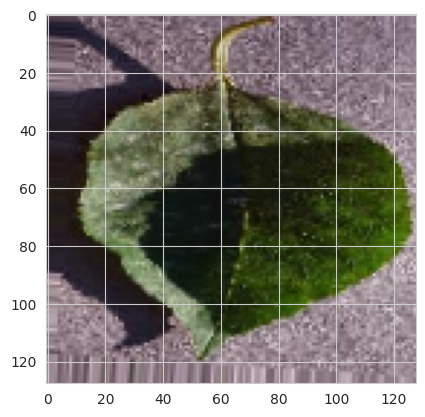

(20, 128, 128, 3)


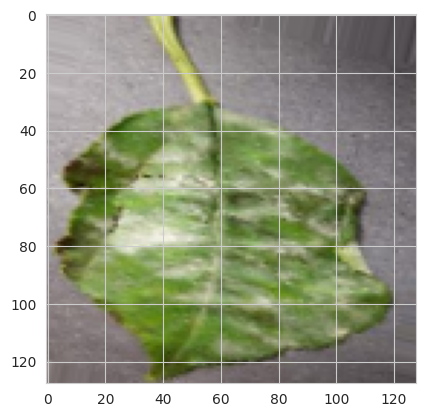

(20, 128, 128, 3)


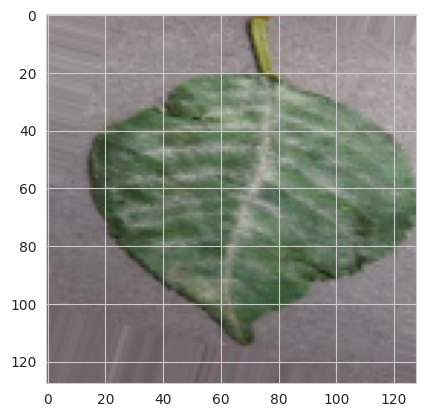

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(20, 128, 128, 3)


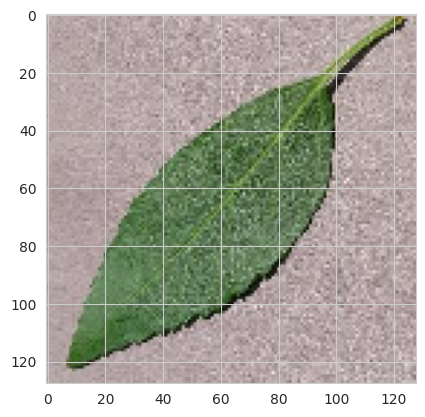

(20, 128, 128, 3)


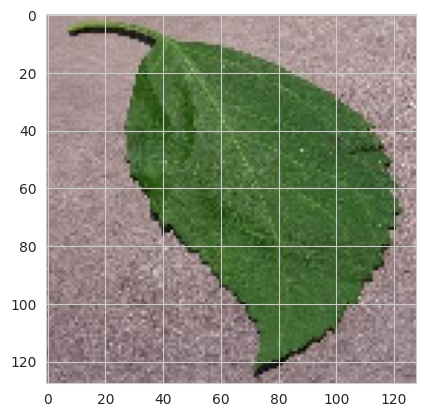

(20, 128, 128, 3)


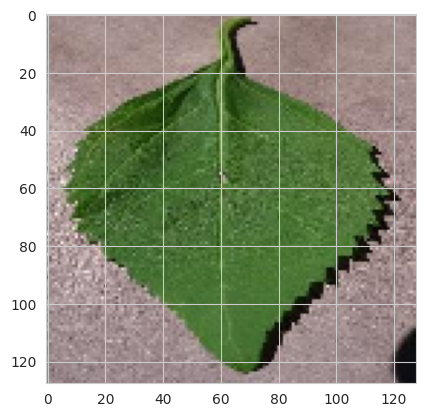

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 128, 128, 3)


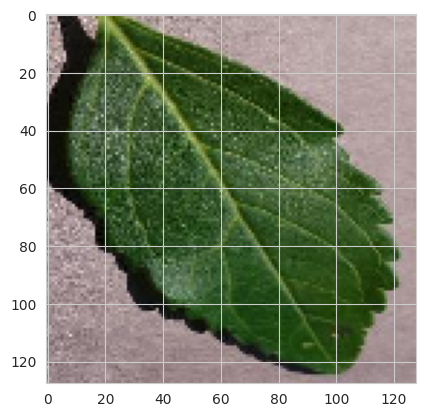

(20, 128, 128, 3)


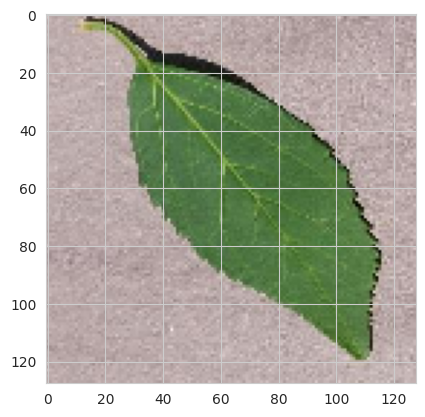

(20, 128, 128, 3)


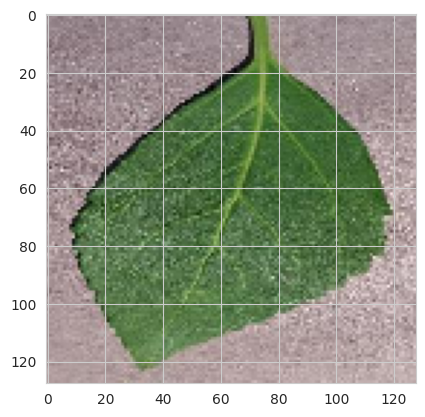

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

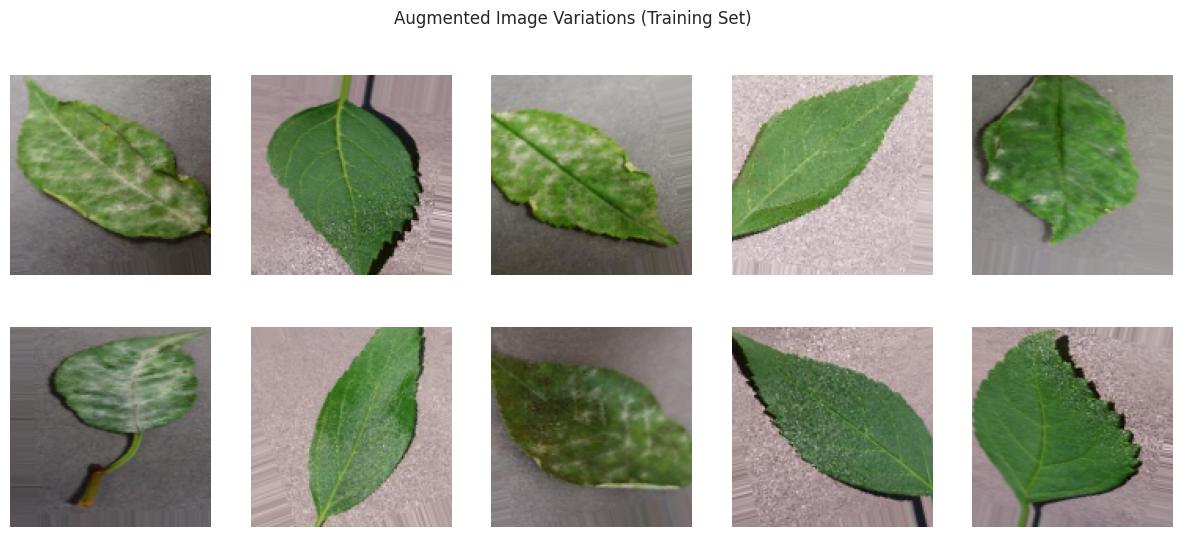

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

## Base MobileNetV2

In [22]:
def create_mobilenetv2():
    """
    Builds a lightweight MobileNetV2-based model for binary classification.
    Returns:
        model (Sequential): A compiled Keras model.
    """
    # Load MobileNetV2 with pre-trained weights, excluding the top classification layer
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

    # Freeze base model layers to retain pre-trained features
    base_model.trainable = False

    # Build the classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),  # Simple dense layer
        Dropout(0.3),  # Dropout for regularization
        Dense(2, activation="softmax")  # Softmax for binary classification
    ])

    # Compile with default settings
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Instantiate and check the model summary
mobilenet_model = create_mobilenetv2()
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

---

## Model Training

### Early Stopping Implementation

In [23]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Set EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

### Fit MobileNetV2 model for training

In [25]:
# Train the base MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_set,  # Replacing train_generator with train_set
    epochs=20,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,  # Ensure consistency
    callbacks=[early_stop],
    verbose=1
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9598 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 1.0000 - loss: 1.9782e-04

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 1.0000 - loss: 1.9782e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9984 - loss: 0.0084 - val_accuracy: 0.9952 - val_loss: 0.0096
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.0000 - loss: 4.6421e-04 - val_accuracy: 0.9952 - val_loss: 0.0132


### Save the Model

In [26]:
# Save the trained base CNN model
mobilenet_model.save("outputs/v3/mildew_detector_mobilenetv2.h5")

---

# Model Performance & Evaluation

---

## Evaluate Mobile on the Test Set

In [27]:
# Evaluate the MobileNetV2 Model
test_loss_mobilenet, test_accuracy_mobilenet = mobilenet_model.evaluate(test_set)

# Print Evaluation Results
print(f"Test Accuracy (MobileNetV2): {test_accuracy_mobilenet:.4f}")
print(f"Test Loss (MobileNetV2): {test_loss_mobilenet:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 9.9220e-04
Test Accuracy (MobileNetV2): 1.0000
Test Loss (MobileNetV2): 0.0007


## Save Training History for Mobile

In [28]:
# Convert training history of MobileNetV2 to DataFrame
import pandas as pd

df_history_mobilenet = pd.DataFrame(history_mobilenet.history)

# Save history for later use
df_history_mobilenet.to_csv("outputs/v3/history_mobilenet.csv", index=False)
print("MobileNetV2 training history saved.")

MobileNetV2 training history saved.


## Model Learning Curve (Loss & Accuracy) for Base CNN

MobileNetV2 training history saved.


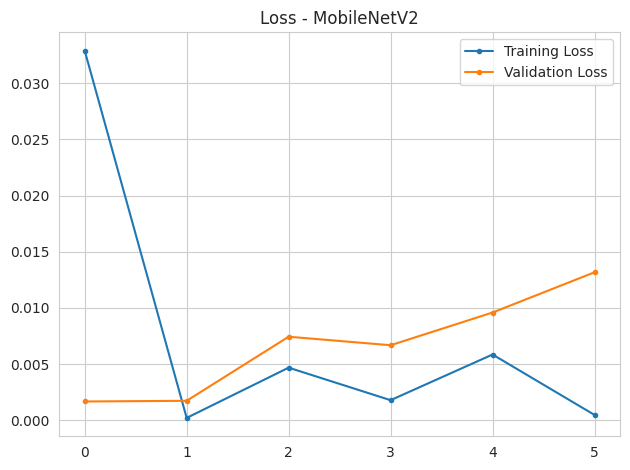

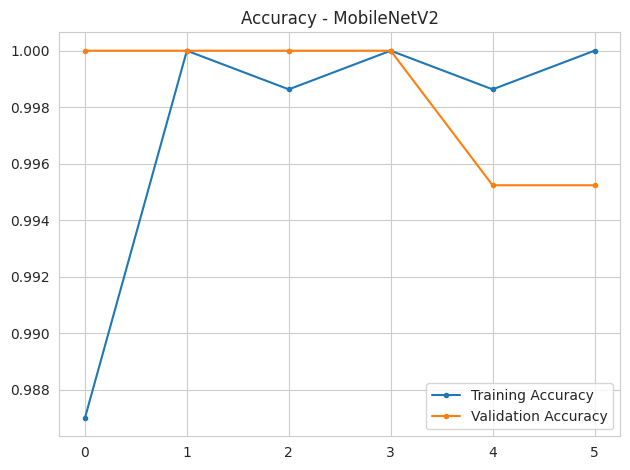

In [30]:
# Convert training history of MobileNetV2 to DataFrame
import pandas as pd

df_history_mobilenet = pd.DataFrame(history_mobilenet.history)  # Fix: Use history_mobilenet instead of mobilenet_model.history

# Save history for later use
df_history_mobilenet.to_csv("outputs/v3/history_mobilenet.csv", index=False)
print("MobileNetV2 training history saved.")

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Ensure 'loss' and 'val_loss' exist before plotting
if "loss" in df_history_mobilenet.columns and "val_loss" in df_history_mobilenet.columns:
    # Plot Loss Curve
    df_history_mobilenet[["loss", "val_loss"]].plot(style=".-")
    plt.title("Loss - MobileNetV2")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("outputs/v3/model_training_losses_mobilenet.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("Warning: 'loss' and 'val_loss' not found in history. Loss plot skipped.")

# Ensure 'accuracy' and 'val_accuracy' exist before plotting
if "accuracy" in df_history_mobilenet.columns and "val_accuracy" in df_history_mobilenet.columns:
    # Plot Accuracy Curve
    df_history_mobilenet[["accuracy", "val_accuracy"]].plot(style=".-")
    plt.title("Accuracy - MobileNetV2")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("outputs/v3/model_training_acc_mobilenet.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("Warning: 'accuracy' and 'val_accuracy' not found in history. Accuracy plot skipped.")

## Confusion Matrix & Classification Report (Train & Test)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Ensure output directory exists
output_dir = "outputs/v3"
os.makedirs(output_dir, exist_ok=True)

# Load the MobileNetV2 Model
mobilenet_model_path = "outputs/v3/mildew_detector_mobilenetv2.h5"
mobilenet_model = load_model(mobilenet_model_path)  


# Function to Generate Confusion Matrix
def generate_confusion_matrix(y_true, y_pred, label_map, set_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_map, columns=label_map)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title(f"Confusion Matrix - {set_name} Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    # Save and show confusion matrix
    save_path = os.path.join(output_dir, f"confusion_matrix_{set_name.lower()}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Confusion Matrix saved at: {save_path}")


# Function to Generate Classification Report
def generate_classification_report(y_true, y_pred, label_map, set_name):
    report = classification_report(y_true, y_pred, target_names=label_map)

    print(f"\n--- Classification Report: {set_name} Set ---\n")
    print(report)

    # Save report as a text file
    report_path = os.path.join(
        output_dir, f"classification_report_{set_name.lower()}.txt"
    )
    with open(report_path, "w") as f:
        f.write(report)

    print(f"Classification report saved at: {report_path}")


# Function to Evaluate the Model
def evaluate_model(generator, model, label_map, set_name):
    """
    Evaluates model performance by generating a confusion matrix and classification report.

    Parameters:
    - generator: Data generator (train, validation, or test)
    - model: Trained model
    - label_map: List of class names
    - set_name: Dataset name (Train, Validation, Test)
    """
    y_true = generator.classes  # True labels

    # Get predictions with correct number of steps
    y_pred_probs = model.predict(generator, steps=len(generator), verbose=1)

    # If using Softmax activation, extract the class with the highest probability
    if y_pred_probs.shape[1] == 2:
        y_pred = np.argmax(y_pred_probs, axis=1)  # Selects the most probable class
    else:
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # For Sigmoid models

    # Ensure matching lengths
    if len(y_true) != len(y_pred):
        print(
            f"Warning: Length mismatch (y_true: {len(y_true)}, y_pred: {len(y_pred)})"
        )
        min_len = min(len(y_true), len(y_pred))
        y_true, y_pred = y_true[:min_len], y_pred[:min_len]

    print(f"\n#### {set_name} Set Evaluation ####\n")

    generate_confusion_matrix(y_true, y_pred, label_map, set_name)
    generate_classification_report(y_true, y_pred, label_map, set_name)


# Get class labels from training set
label_map = list(train_set.class_indices.keys())

# Evaluate the MobileNetV2 Model on Train and Test Sets
evaluate_model(train_set, mobilenet_model, label_map, "Train")
evaluate_model(test_set, mobilenet_model, label_map, "Test")

## Histgrams for Mobile

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


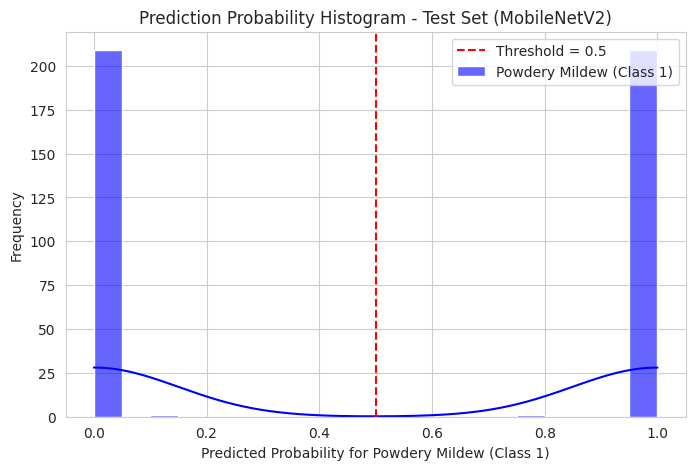

Histogram saved at: outputs/v3/histogram_test.png


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mobilenet_histogram(model, generator, set_name="Test"):
    """
    Generates and saves a histogram of predicted probabilities for the MobileNetV2 CNN model.

    Parameters:
    - model: Trained MobileNetV2 CNN model
    - generator: Data generator (e.g., train, validation, test)
    - set_name: Name of the dataset ("Train", "Validation", "Test")
    """
    # Get true labels and predicted probabilities
    y_true = generator.classes
    y_pred_probs = model.predict(generator)  # Get softmax probability outputs

    # Fix: Extract probabilities correctly for **binary classification**
    y_pred_class1_probs = y_pred_probs[:, 0]  # Probability for Class 1 (Powdery Mildew)

    # Plot histogram for positive class (Powdery Mildew)
    plt.figure(figsize=(8, 5))
    sns.histplot(
        y_pred_class1_probs,
        bins=20,
        kde=True,
        color="blue",
        alpha=0.6,
        label="Powdery Mildew (Class 1)",
    )
    plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")
    plt.title(f"Prediction Probability Histogram - {set_name} Set (MobileNetV2)")
    plt.xlabel("Predicted Probability for Powdery Mildew (Class 1)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)

    # Save histogram
    hist_path = f"outputs/v3/histogram_{set_name.lower()}.png"
    plt.savefig(hist_path, dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Histogram saved at: {hist_path}")

# Run histogram plot for test set
plot_mobilenet_histogram(mobilenet_model, validation_set, "Test")

## Save Evaluation Pickle

In [ ]:
import joblib

# Store evaluation results with the correct variable names
evaluation_mobilenet = {
    "test_loss": test_loss_mobilenet,
    "test_accuracy": test_accuracy_mobilenet,
}

# Save evaluation results
joblib.dump(value=evaluation_mobilenet, filename="outputs/v3/evaluation_mobilenet.pkl")
print("\nMobileNetV2 model evaluation results saved!")

## Save the Best Tuned Model

In [ ]:
best_model.save("outputs/v1/mildew_detector_cnn_tuned.keras")

---

# Predict on New Images

---

## Load & Predict on Sample Image

### Load the Final Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the final trained model
model = load_model("outputs/v1/final_mildew_detector.keras")

### Select and Load a Random Test Image

In [ ]:
from tensorflow.keras.preprocessing import image
import os

# Define test image selection parameters
pointer = 60  # Change this number to select a different image
label = labels[1]  # Select "Healthy" (0) or "Infected" (1)

# Load the image using PIL
img_path = test_path + "/" + label + "/" + os.listdir(test_path + "/" + label)[pointer]
pil_image = image.load_img(img_path, target_size=image_shape, color_mode="rgb")

# Display image details
print(f"Selected Image Path: {img_path}")
print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")

# Show the image
pil_image

### Make Prediction & Display Result

In [ ]:
# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]  # Extract single probability score

# Map indices to class labels
target_map = {v: k for k, v in train_set.class_indices.items()}  # Reverse mapping
pred_class = target_map[int(pred_proba > 0.5)]  # Ensure correct label mapping

# Adjust probability if necessary
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Print prediction results
print(f"Predicted Class: {pred_class}")
print(f"Prediction Probability: {pred_proba:.4f}")

---

# Conclusion and Next Steps

---

In this project, we successfully developed a deep learning model to detect Powdery Mildew on Cherry Leaves using a structured, beginner-friendly approach.

## Key Achievements
- Baseline CNN Implementation → Developed an initial CNN model to establish a performance benchmark.
- Optimized Hyperparameter Tuning → Applied systematic tuning (adjusting filters, dropout, learning rate, and L2 regularization) to enhance model performance while balancing computational efficiency.
- Model Evaluation & Comparison → Assessed the baseline and optimized CNN models based on accuracy, loss, and generalization ability.
- Explainability with Saliency Maps → Visualized important regions influencing the model’s predictions, enhancing interpretability.
- Final Model Selection → The Hyperparameter-Tuned CNN was chosen based on its superior accuracy and robustness for real-world deployment.

## Next Steps: Model Deployment

The next step is to integrate the optimized CNN model into a user-friendly application that allows real-time classification of leaf images.

Deployment Plan
- Develop an Interactive Web App → Implement a Streamlit-based interface where users can upload leaf images for classification.
- Integrate the Tuned CNN Model → Load the trained model to process new images and predict mildew presence.
- Deploy on a Cloud Platform → Host the web application using Streamlit and Heroku for accessibility.

This deployment will enable real-time detection of powdery mildew, aiding efficient disease monitoring and automated plantation management.
